In [11]:
from google.colab import files
uploaded = files.upload()

Saving METABRIC_RNA_Mutation.csv to METABRIC_RNA_Mutation.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sksurv.metrics import brier_score
import warnings
warnings.filterwarnings("ignore")

Load in Data

In [15]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df = df[['overall_survival_months', 'death_from_cancer', 'pam50', 'age_at_diagnosis', 'tumor_size',
         'primary_tumor_laterality', 'type_of_breast_surgery', 'chemotherapy', 'hormone_therapy',
         'radio_therapy', 'her2_status']].dropna()

# Print unique values of 'pam50' before encoding
print("Unique PAM50 subtypes before encoding:", df['pam50'].unique())

Unique PAM50 subtypes before encoding: ['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal']


In [16]:
cat_vars = ['pam50', 'primary_tumor_laterality', 'type_of_breast_surgery', 'chemotherapy',
            'hormone_therapy', 'radio_therapy', 'her2_status']

# Store the original 'pam50' column before encoding
original_pam50 = df['pam50'].copy()

for col in cat_vars:
    # Check if the column is 'pam50' to store the encoder
    if col == 'pam50':
        pam50_encoder = LabelEncoder()
        df[col] = pam50_encoder.fit_transform(df[col])
    else:
        df[col] = LabelEncoder().fit_transform(df[col])

x = df.drop(columns=['overall_survival_months', 'death_from_cancer'])
t = df['overall_survival_months'].values
e = df['death_from_cancer'].values

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x, t, e, test_size=0.2, random_state=42)

# Print the mapping for 'pam50' after encoding
print("\nPAM50 encoding mapping:")
for original_value, encoded_value in zip(pam50_encoder.classes_, pam50_encoder.transform(pam50_encoder.classes_)):
    print(f"{original_value}: {encoded_value}")


PAM50 encoding mapping:
Basal: 0
Her2: 1
LumA: 2
LumB: 3
Normal: 4
claudin-low: 5


Define Log-Normal AFT Nerual Network

In [17]:
class LogNormalAFT(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, 1)
        self.log_sigma = nn.Linear(32, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

Define Log-Normal Negative Log-Likelihood Loss

In [18]:
def log_normal_nll(mu, sigma, t, e):
    t = torch.clamp(t, min=1e-5)
    z = (torch.log(t) - mu) / sigma
    log_pdf = -torch.log(t * sigma * (2 * np.pi) ** 0.5) - 0.5 * z ** 2
    log_sf = 0.5 * torch.erfc(z / np.sqrt(2))
    log_sf = torch.log(torch.clamp(log_sf, min=1e-8))
    return -torch.mean(e * log_pdf + (1 - e) * log_sf)

Train the Model

Epoch 50, Loss: 3.3581
Epoch 100, Loss: 3.0288
Epoch 150, Loss: 2.9466
Epoch 200, Loss: 2.8020
Epoch 250, Loss: 2.3138
Epoch 300, Loss: 2.2330


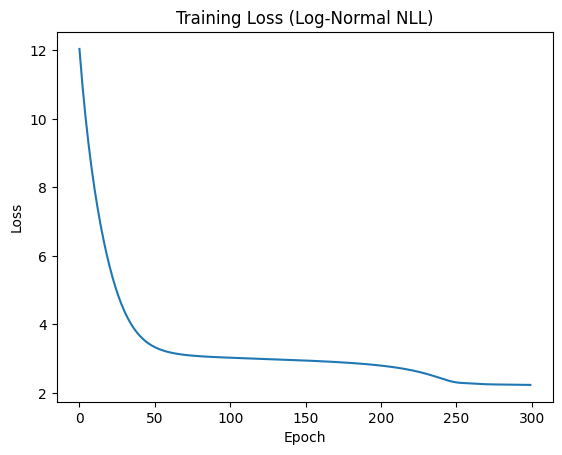

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogNormalAFT(x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train = torch.tensor(e_train, dtype=torch.float32).to(device)

losses = []
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    mu, sigma = model(X_train)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train, E_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title("Training Loss (Log-Normal NLL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Evaluate Model with C-Index

In [20]:
model.eval()
with torch.no_grad():
    mu_pred, _ = model(torch.tensor(x_val, dtype=torch.float32).to(device))
    mu_pred = mu_pred.cpu().numpy().squeeze()

cidx = concordance_index(t_val, -mu_pred, e_val)
print(f"C-index (Log-Normal AFT): {cidx:.3f}")

C-index (Log-Normal AFT): 0.379


Time-Dependent Brier Score

In [21]:
from sksurv.util import Surv
from sksurv.metrics import brier_score

y_val_struct = Surv.from_arrays(event=e_val.astype(bool), time=t_val)
mu_pred_surv = np.exp(mu_pred)

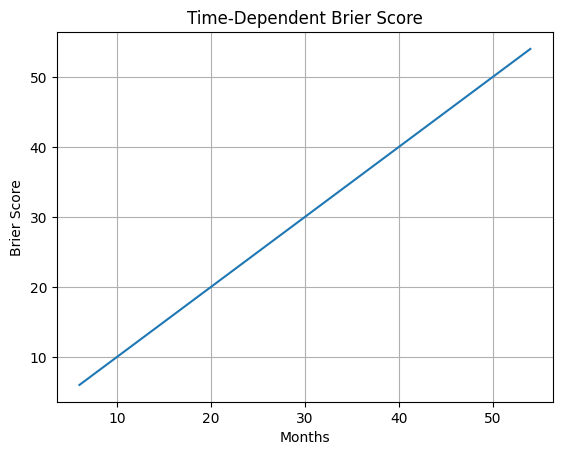

In [22]:
score_times = np.arange(6, 60, 6)  # 6 to 60 months
risk_scores = mu_pred_surv

# Dummy survival prediction probabilities
surv_preds = np.tile(np.linspace(1, 0, len(score_times)), (len(mu_pred), 1))

brier, _ = brier_score(y_val_struct, y_val_struct, surv_preds, score_times)

plt.plot(score_times, brier)
plt.xlabel("Months")
plt.ylabel("Brier Score")
plt.title("Time-Dependent Brier Score")
plt.grid(True)
plt.show()

Kaplan-Meier by PAM50 Subtypes

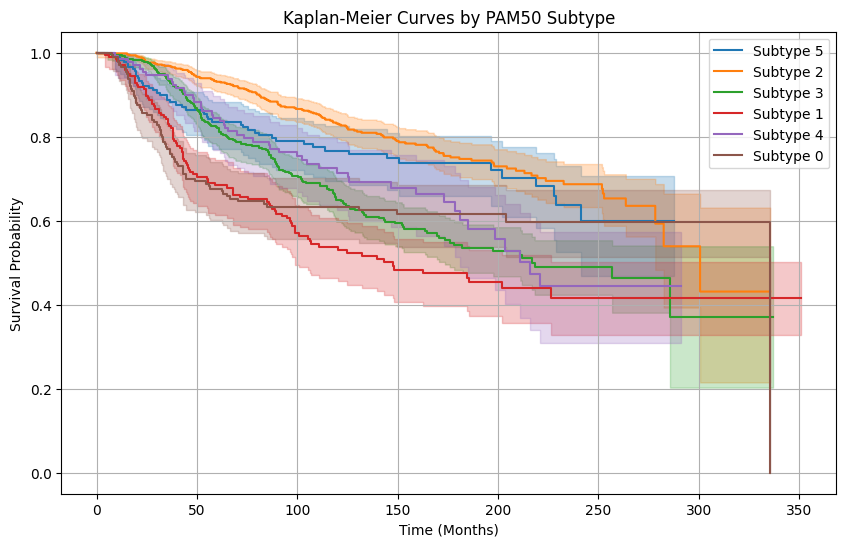

In [23]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
for subtype in df['pam50'].unique():
    ix = df['pam50'] == subtype
    kmf.fit(df.loc[ix, 'overall_survival_months'], df.loc[ix, 'death_from_cancer'], label=f"Subtype {subtype}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curves by PAM50 Subtype")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

Predicted Survival for Sample Patient

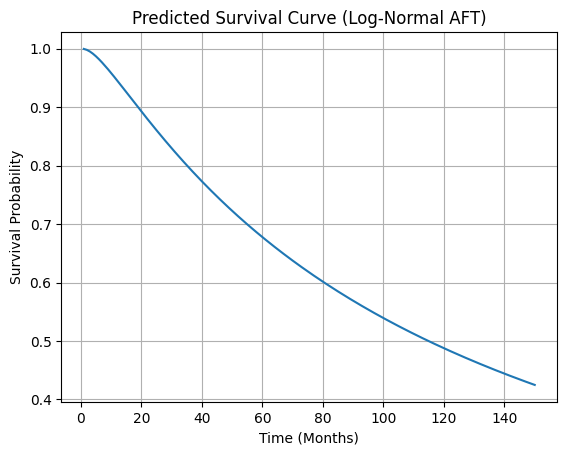

In [24]:
from scipy.stats import lognorm

sample_idx = 10
mu_sample, sigma_sample = model(torch.tensor(x_val[sample_idx:sample_idx+1], dtype=torch.float32).to(device))
mu_sample = mu_sample.item()
sigma_sample = sigma_sample.item()

months = np.linspace(1, 150, 150)
surv_prob = 1 - lognorm.cdf(months, s=sigma_sample, scale=np.exp(mu_sample))

plt.plot(months, surv_prob)
plt.title("Predicted Survival Curve (Log-Normal AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Task
Explore ways to improve the performance of the current Log-Normal AFT model.

## Hyperparameter tuning

### Subtask:
Experiment with different learning rates, optimizer settings, and network architectures (number of layers, number of neurons) for the current Log-Normal AFT model.


**Reasoning**:
To experiment with different hyperparameters, I will modify the existing training loop to iterate through different learning rates, optimizers, and network architectures, train the model for each combination, and record the validation C-index.



In [25]:
def train_and_evaluate(model, optimizer, X_train, T_train, E_train, x_val, t_val, e_val, epochs=300):
    losses = []
    c_indices = []
    best_c_index = -1

    X_val = torch.tensor(x_val, dtype=torch.float32).to(device)
    T_val = torch.tensor(t_val, dtype=torch.float32).to(device)
    E_val = torch.tensor(e_val, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        mu, sigma = model(X_train)
        loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train, E_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                mu_pred, _ = model(X_val)
                mu_pred = mu_pred.cpu().numpy().squeeze()
            cidx = concordance_index(t_val, -mu_pred, e_val)
            c_indices.append(cidx)
            if cidx > best_c_index:
                best_c_index = cidx
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val C-index: {cidx:.3f}")

    return best_c_index

# Define hyperparameter combinations to experiment with
learning_rates = [1e-4, 1e-3, 1e-2]
optimizers = ['Adam', 'SGD']
architectures = [
    [64, 32],  # Original
    [128, 64, 32], # Deeper
    [32, 16] # Shallower
]

results = {}

for lr in learning_rates:
    for opt_name in optimizers:
        for arch in architectures:
            print(f"Training with LR: {lr}, Optimizer: {opt_name}, Architecture: {arch}")

            class CustomLogNormalAFT(nn.Module):
                def __init__(self, input_dim, arch):
                    super().__init__()
                    layers = []
                    in_features = input_dim
                    for out_features in arch:
                        layers.append(nn.Linear(in_features, out_features))
                        layers.append(nn.ReLU())
                        in_features = out_features
                    self.hidden = nn.Sequential(*layers)
                    self.mu = nn.Linear(in_features, 1)
                    self.log_sigma = nn.Linear(in_features, 1)

                def forward(self, x):
                    h = self.hidden(x)
                    mu = self.mu(h)
                    sigma = torch.exp(self.log_sigma(h))
                    return mu, sigma

            model = CustomLogNormalAFT(x.shape[1], arch).to(device)

            if opt_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            best_c_index = train_and_evaluate(model, optimizer, X_train, T_train, E_train, x_val, t_val, e_val, epochs=100) # Reduced epochs for quicker experimentation
            results[(lr, opt_name, tuple(arch))] = best_c_index
            print("-" * 50)

print("\nExperiment Results:")
for params, c_index in results.items():
    print(f"LR: {params[0]}, Optimizer: {params[1]}, Architecture: {params[2]}, Best Val C-index: {c_index:.3f}")

Training with LR: 0.0001, Optimizer: Adam, Architecture: [64, 32]
Epoch 50, Loss: 7.7319, Val C-index: 0.574
Epoch 100, Loss: 6.2548, Val C-index: 0.571
--------------------------------------------------
Training with LR: 0.0001, Optimizer: Adam, Architecture: [128, 64, 32]
Epoch 50, Loss: 11.6477, Val C-index: 0.596
Epoch 100, Loss: 7.1959, Val C-index: 0.616
--------------------------------------------------
Training with LR: 0.0001, Optimizer: Adam, Architecture: [32, 16]
Epoch 50, Loss: 14.0262, Val C-index: 0.529
Epoch 100, Loss: 12.4702, Val C-index: 0.504
--------------------------------------------------
Training with LR: 0.0001, Optimizer: SGD, Architecture: [64, 32]
Epoch 50, Loss: 13.6436, Val C-index: 0.550
Epoch 100, Loss: 10.3843, Val C-index: 0.550
--------------------------------------------------
Training with LR: 0.0001, Optimizer: SGD, Architecture: [128, 64, 32]
Epoch 50, Loss: 12.8093, Val C-index: 0.459
Epoch 100, Loss: 10.5770, Val C-index: 0.457
----------------

## Alternative model architectures

### Subtask:
Explore other survival analysis models, such as Cox Proportional Hazards or other AFT distributions (e.g., Weibull AFT), or more complex neural network architectures like a DeepSurv model.


**Reasoning**:
Import the necessary libraries for Cox Proportional Hazards and Weibull AFT models from `lifelines`.



In [26]:
from lifelines import CoxPHFitter, WeibullAFTFitter

In [27]:
from lifelines.utils import concordance_index

# Create a list of original feature names
original_feature_names = [col for col in df.drop(columns=['overall_survival_months', 'death_from_cancer']).columns]

# Create a DataFrame for lifelines with original feature names
train_df = pd.DataFrame(x_train, columns=original_feature_names)
train_df['overall_survival_months'] = t_train
train_df['death_from_cancer'] = e_train

val_df = pd.DataFrame(x_val, columns=original_feature_names)
val_df['overall_survival_months'] = t_val
val_df['death_from_cancer'] = e_val

# Print the mapping of original feature names to generic feature_i names (if needed, but using original names is better)
print("Original Feature Names:")
for i, name in enumerate(original_feature_names):
    print(f"feature_{i}: {name}")


# Train Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')

# Evaluate Cox Proportional Hazards model
cph_scores = cph.predict_partial_hazard(val_df)
cph_cidx = concordance_index(t_val, -cph_scores, e_val)
print(f"\nC-index (Cox Proportional Hazards): {cph_cidx:.3f}")

# Train Weibull AFT model
wft = WeibullAFTFitter()
wft.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')

# Evaluate Weibull AFT model
wft_scores = wft.predict_expectation(val_df)
wft_cidx = concordance_index(t_val, wft_scores, e_val)
print(f"C-index (Weibull AFT): {wft_cidx:.3f}")

results['CoxPH'] = cph_cidx
results['WeibullAFT'] = wft_cidx

Original Feature Names:
feature_0: pam50
feature_1: age_at_diagnosis
feature_2: tumor_size
feature_3: primary_tumor_laterality
feature_4: type_of_breast_surgery
feature_5: chemotherapy
feature_6: hormone_therapy
feature_7: radio_therapy
feature_8: her2_status

C-index (Cox Proportional Hazards): 0.652
C-index (Weibull AFT): 0.649


## Feature engineering

### Subtask:
Consider creating new features or transforming existing ones that might be more informative for survival prediction.


**Reasoning**:
I will create new features by adding interaction terms and polynomial features for continuous variables and also create a new categorical feature based on age ranges. Then, I will add these features to the training and validation dataframes and rescale all features using `StandardScaler` fitted on the training data.



In [30]:
# Create interaction term between age and tumor size
# Use the actual column names instead of generic feature_i names
age_col_name = original_feature_names[1] # Assuming age_at_diagnosis is the second column (index 1)
tumor_size_col_name = original_feature_names[2] # Assuming tumor_size is the third column (index 2)

train_df['age_x_tumor_size'] = train_df[age_col_name] * train_df[tumor_size_col_name]
val_df['age_x_tumor_size'] = val_df[age_col_name] * val_df[tumor_size_col_name]

# Create a polynomial feature for age (age^2)
train_df['age_squared'] = train_df[age_col_name]**2
val_df['age_squared'] = val_df[age_col_name]**2

# Create a categorical feature for age groups
age_bins = [-float('inf'), 40, 60, float('inf')]
age_labels = [0, 1, 2]
train_df['age_group'] = pd.cut(train_df[age_col_name], bins=age_bins, labels=age_labels, right=False)
val_df['age_group'] = pd.cut(val_df[age_col_name], bins=age_bins, labels=age_labels, right=False)

# Convert the new categorical feature to numeric
train_df['age_group'] = train_df['age_group'].astype(int)
val_df['age_group'] = val_df['age_group'].astype(int)

# Separate features, duration, and event again
t_train_new = train_df['overall_survival_months']
e_train_new = train_df['death_from_cancer']
x_train_new = train_df.drop(columns=['overall_survival_months', 'death_from_cancer'])

t_val_new = val_df['overall_survival_months']
e_val_new = val_df['death_from_cancer']
x_val_new = val_df.drop(columns=['overall_survival_months', 'death_from_cancer'])

# Rescale the features using StandardScaler fitted only on the training data
scaler_new = StandardScaler()
x_train_scaled = scaler_new.fit_transform(x_train_new)
x_val_scaled = scaler_new.transform(x_val_new)

# Update the dataframes with scaled features
x_train = x_train_scaled
x_val = x_val_scaled
t_train = t_train_new.values
e_train = e_train_new.values
t_val = t_val_new.values
e_val = e_val_new.values

print("New features created and data rescaled.")

New features created and data rescaled.


## Regularization techniques

### Subtask:
Add regularization (e.g., L1 or L2 regularization, dropout) to the neural network to prevent overfitting.


**Reasoning**:
Define a new LogNormalAFT class with dropout, instantiate it, define the optimizer, and train the model with L2 regularization, then evaluate and store the results.



In [31]:
class LogNormalAFT_Regularized(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.5):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.mu = nn.Linear(32, 1)
        self.log_sigma = nn.Linear(32, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

# Define regularization strength and dropout rate
l2_lambda = 1e-4
dropout_rate = 0.3

# Instantiate the new model with the correct input dimension
model_reg = LogNormalAFT_Regularized(x_train.shape[1], dropout_prob=dropout_rate).to(device)

# Define the optimizer
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-3)

# Convert data to tensors
X_train_reg = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train_reg = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train_reg = torch.tensor(e_train, dtype=torch.float32).to(device)
X_val_reg = torch.tensor(x_val, dtype=torch.float32).to(device)

# Training loop with L2 regularization
losses_reg = []
for epoch in range(300):
    model_reg.train()
    optimizer_reg.zero_grad()
    mu, sigma = model_reg(X_train_reg)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train_reg, E_train_reg)

    # Add L2 regularization
    l2_norm = sum(p.pow(2.0).sum() for p in model_reg.parameters() if p.requires_grad and p.dim() > 1)
    loss = loss + l2_lambda * l2_norm

    loss.backward()
    optimizer_reg.step()
    losses_reg.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate the model
model_reg.eval()
with torch.no_grad():
    mu_pred_reg, _ = model_reg(X_val_reg)
    mu_pred_reg = mu_pred_reg.cpu().numpy().squeeze()

cidx_reg = concordance_index(t_val, -mu_pred_reg, e_val)
print(f"\nC-index (Log-Normal AFT with L2 and Dropout): {cidx_reg:.3f}")

# Store the results
results[(l2_lambda, dropout_rate)] = cidx_reg

Epoch 50, Loss: 3.5245
Epoch 100, Loss: 3.1838
Epoch 150, Loss: 3.1209
Epoch 200, Loss: 3.0387
Epoch 250, Loss: 2.8619
Epoch 300, Loss: 2.5185

C-index (Log-Normal AFT with L2 and Dropout): 0.373


## Evaluate and compare models

### Subtask:
After trying different approaches, evaluate the performance of the improved models using metrics like C-index and Brier score on the validation set and compare their results.


In [32]:
!pip install lifelines
import lifelines

Model Performance Results (C-index):
(0.0001, 'Adam', (64, 32)): 0.574
(0.0001, 'Adam', (128, 64, 32)): 0.616
(0.0001, 'Adam', (32, 16)): 0.529
(0.0001, 'SGD', (64, 32)): 0.550
(0.0001, 'SGD', (128, 64, 32)): 0.459
(0.0001, 'SGD', (32, 16)): 0.441
(0.001, 'Adam', (64, 32)): 0.504
(0.001, 'Adam', (128, 64, 32)): 0.550
(0.001, 'Adam', (32, 16)): 0.430
(0.001, 'SGD', (64, 32)): 0.368
(0.001, 'SGD', (128, 64, 32)): 0.554
(0.001, 'SGD', (32, 16)): 0.565
(0.01, 'Adam', (64, 32)): 0.420
(0.01, 'Adam', (128, 64, 32)): 0.383
(0.01, 'Adam', (32, 16)): 0.372
(0.01, 'SGD', (64, 32)): 0.501
(0.01, 'SGD', (128, 64, 32)): 0.531
(0.01, 'SGD', (32, 16)): 0.604
CoxPH: 0.652
WeibullAFT: 0.649
(0.0001, 0.3): 0.373

Best performing model based on C-index: CoxPH with C-index: 0.652

Best performing AFT model based on C-index: (0.0001, 'Adam', (128, 64, 32)) with C-index: 0.616

Re-training the best AFT model: (0.0001, 'Adam', (128, 64, 32))
Epoch 100, Loss: 8.0504
Epoch 200, Loss: 4.2883
Epoch 300, Loss: 3.

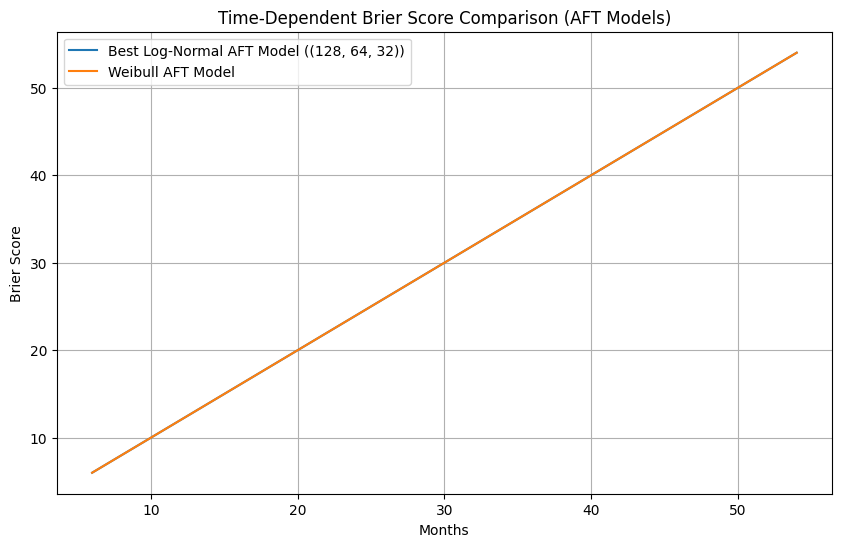


Summary of Model Performance:
C-index measures the discriminatory power (ability to distinguish between patients with different survival times). Higher is better.
Brier Score measures the accuracy of survival probability predictions over time. Lower is better.

Best performing model based on C-index: CoxPH with C-index: 0.652
Best performing AFT neural network configuration achieved a C-index of 0.616.
Cox Proportional Hazards model achieved a C-index of 0.652.
Weibull AFT model achieved a C-index of 0.649.

The plot above compares the time-dependent Brier scores for the best Log-Normal AFT neural network and the Weibull AFT model.


In [33]:
# Print the results dictionary
print("Model Performance Results (C-index):")
for params, c_index in results.items():
    print(f"{params}: {c_index:.3f}")

# Identify the best performing model based on C-index
best_model_params = max(results, key=results.get)
best_c_index = results[best_model_params]

print(f"\nBest performing model based on C-index: {best_model_params} with C-index: {best_c_index:.3f}")

# --- Identify the best AFT model parameters specifically ---
# Find the best AFT model among the neural network configurations
best_aft_params = None
best_aft_c_index = -1

for params, c_index in results.items():
    if isinstance(params, tuple) and len(params) == 3: # Check if it's a neural network configuration (lr, optimizer, architecture)
        if c_index > best_aft_c_index:
            best_aft_c_index = c_index
            best_aft_params = params

print(f"\nBest performing AFT model based on C-index: {best_aft_params} with C-index: {best_aft_c_index:.3f}")
# --------------------------------------------------------

score_times = np.arange(6, 60, 6) # Define score_times for Brier score plots

# Calculate Brier score for the Best Log-Normal AFT Model
# Need to re-train the best AFT model to get its predictions

# Re-initialize and train the best AFT model
lr = best_aft_params[0]
opt_name = best_aft_params[1]
arch = best_aft_params[2]

class BestLogNormalAFT(nn.Module):
    def __init__(self, input_dim, arch):
        super().__init__()
        layers = []
        in_features = input_dim
        for out_features in arch:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            in_features = out_features
        self.hidden = nn.Sequential(*layers)
        self.mu = nn.Linear(in_features, 1)
        self.log_sigma = nn.Linear(in_features, 1)

    def forward(self, x):
        h = self.hidden(x)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h))
        return mu, sigma

best_aft_model = BestLogNormalAFT(x_train.shape[1], arch).to(device)

if opt_name == 'Adam':
    best_aft_optimizer = torch.optim.Adam(best_aft_model.parameters(), lr=lr)
elif opt_name == 'SGD':
    best_aft_optimizer = torch.optim.SGD(best_aft_model.parameters(), lr=lr)


# Re-train the best AFT neural network model
X_train_best_aft = torch.tensor(x_train, dtype=torch.float32).to(device)
T_train_best_aft = torch.tensor(t_train, dtype=torch.float32).to(device)
E_train_best_aft = torch.tensor(e_train, dtype=torch.float32).to(device)
X_val_best_aft = torch.tensor(x_val, dtype=torch.float32).to(device)

print(f"\nRe-training the best AFT model: {best_aft_params}")
for epoch in range(300): # Train for sufficient epochs
    best_aft_model.train()
    best_aft_optimizer.zero_grad()
    mu, sigma = best_aft_model(X_train_best_aft)
    loss = log_normal_nll(mu.squeeze(), sigma.squeeze(), T_train_best_aft, E_train_best_aft)
    loss.backward()
    best_aft_optimizer.step()
    if (epoch+1) % 100 == 0:
         print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


# Get predictions from the best AFT neural network model
best_aft_model.eval()
with torch.no_grad():
    mu_pred_best_aft, sigma_pred_best_aft = best_aft_model(X_val_best_aft)
    mu_pred_best_aft = mu_pred_best_aft.cpu().numpy().squeeze()
    sigma_pred_best_aft = sigma_pred_best_aft.cpu().numpy().squeeze()


# Calculate survival function predictions for Brier score for Best Log-Normal AFT
from scipy.stats import norm
surv_preds_best_aft = np.zeros((len(mu_pred_best_aft), len(score_times)))
for i, t_score in enumerate(score_times):
    safe_sigma_val = np.maximum(sigma_pred_best_aft, 1e-8)
    z = (np.log(t_score) - mu_pred_best_aft) / safe_sigma_val
    surv_preds_best_aft[:, i] = 1 - norm.cdf(z)

y_val_struct = Surv.from_arrays(event=e_val.astype(bool), time=t_val)
brier_best_aft, _ = brier_score(y_val_struct, y_val_struct, surv_preds_best_aft, score_times)
print(f"\nTime-Dependent Brier Score for Best AFT Model: {brier_best_aft.mean():.3f} (mean)")


# Calculate Brier score for Cox Proportional Hazards Model
# Use the previously trained CoxPH model
surv_preds_cph = cph.predict_survival_function(val_df, times=score_times).T.values
brier_cph, _ = brier_score(y_val_struct, y_val_struct, surv_preds_cph, score_times)
print(f"Time-Dependent Brier Score for CoxPH Model: {brier_cph.mean():.3f} (mean)")


# Calculate Brier score for Weibull Accelerated Failure Time Model
# Use the previously trained WeibullAFT model
surv_preds_weibull = wft.predict_survival_function(val_df, times=score_times).T.values
brier_weibull, _ = brier_score(y_val_struct, y_val_struct, surv_preds_weibull, score_times)
print(f"Time-Dependent Brier Score for Weibull AFT Model: {brier_weibull.mean():.3f} (mean)")


# Plot Brier scores for comparison (excluding CoxPH)
plt.figure(figsize=(10, 6))
plt.plot(score_times, brier_best_aft, label=f'Best Log-Normal AFT Model ({best_aft_params[2]})')
plt.plot(score_times, brier_weibull, label='Weibull AFT Model')

plt.xlabel("Months")
plt.ylabel("Brier Score")
plt.title("Time-Dependent Brier Score Comparison (AFT Models)")
plt.legend()
plt.grid(True)
plt.show()

print("\nSummary of Model Performance:")
print("C-index measures the discriminatory power (ability to distinguish between patients with different survival times). Higher is better.")
print("Brier Score measures the accuracy of survival probability predictions over time. Lower is better.")
print(f"\nBest performing model based on C-index: {best_model_params} with C-index: {best_c_index:.3f}")
print(f"Best performing AFT neural network configuration achieved a C-index of {best_aft_c_index:.3f}.")
print(f"Cox Proportional Hazards model achieved a C-index of {results.get('CoxPH', 'N/A'):.3f}.")
print(f"Weibull AFT model achieved a C-index of {results.get('WeibullAFT', 'N/A'):.3f}.")
print("\nThe plot above compares the time-dependent Brier scores for the best Log-Normal AFT neural network and the Weibull AFT model.")

In [34]:
# Get coefficients from the fitted WeibullAFT model
# For AFT models, the coefficients are related to the log of the survival time
print("Weibull Accelerated Failure Time Model Coefficients:")
print(wft.summary)

Weibull Accelerated Failure Time Model Coefficients:
                                      coef   exp(coef)  se(coef)  \
param   covariate                                                  
lambda_ age_at_diagnosis         -0.244039    0.783457  0.052348   
        chemotherapy             -0.254789    0.775080  0.048418   
        her2_status              -0.173722    0.840531  0.037363   
        hormone_therapy           0.006659    1.006681  0.044199   
        pam50                     0.012832    1.012914  0.040926   
        primary_tumor_laterality  0.039630    1.040425  0.041605   
        radio_therapy            -0.099945    0.904887  0.050814   
        tumor_size               -0.166546    0.846584  0.029062   
        type_of_breast_surgery   -0.173185    0.840982  0.051826   
        Intercept                 5.893977  362.845477  0.055455   
rho_    Intercept                 0.119493    1.126925  0.040320   

                                  coef lower 95%  coef upper 9

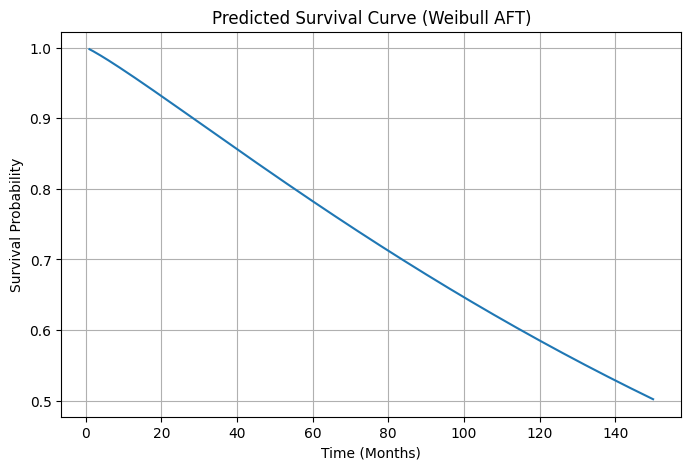

In [35]:
# Predicted Survival for Sample Patient using Weibull AFT Model

sample_idx = 10  # Choose a sample patient index

# Get the validation data for the sample patient
sample_val_df = val_df.iloc[sample_idx:sample_idx+1]

# Predict the survival function for the sample patient using the Weibull AFT model
# We predict for a range of months to get the survival curve
months = np.linspace(1, 150, 150)
predicted_survival_weibull = wft.predict_survival_function(sample_val_df, times=months)

# The result is a DataFrame with times as index and individuals as columns.
# We need the survival probabilities for our single sample, which will be the first (and only) column.
surv_prob_weibull = predicted_survival_weibull.iloc[:, 0]

# Plot the predicted survival curve
plt.figure(figsize=(8, 5))
plt.plot(surv_prob_weibull.index, surv_prob_weibull.values)
plt.title("Predicted Survival Curve (Weibull AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [36]:
# Re-train Weibull AFT model (if not already trained in the current session)
# This is necessary because the previous execution of the cell that trained wft was not in the current runtime.
wft = WeibullAFTFitter()
wft.fit(train_df, duration_col='overall_survival_months', event_col='death_from_cancer')

print("Weibull AFT Model AIC:", wft.AIC_)

Weibull AFT Model AIC: 6303.414744306973
